# Analyse de données de films
IA & Data science (3i026) Project -- 2018-2019
--------

# Binome: DJEGHRI Amine & BELAREF Nail
### Ceci est le fichier numéro 1, il existe un autre fichier qui contient les 2 autres problèmatiques

Ce projet s'intéresse à l'analyse de données décrivant des films. Les données sont obtenues à partir de la base de donnée MovieLens, et sont disponibles sur: https://grouplens.org/datasets/movielens/ au format CSV.Nous avons également d'autres données récupérées sur TMdb au formal pkl, disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl ,   
http://webia.lip6.fr/~guigue/act_v2.pkl  ,  
http://webia.lip6.fr/~guigue/crew_v2.pkl


Dans le jeu de données MovieLens, nous disposons entre autre de 4 fichiers csv:

Le fichier 'movies' contenant l'idendifiant du film dans IMdb et TMdb,le titre du film et sa catégorie(s) 

Le fichier 'movies2' contenant le budjet , gros, star du film ... 

Le fichier 'ratings' contient les notes données par les internautes aux films

Le fichier 'tags' contient des tags d'un utilisateur pour un film

Le fichier 'links' quand à lui contient les correspondances entre les IDs du film sur MovieLens, IMDb et TMDb

Dans les autres fichiers d'enrichissement,nous avons une nouvelle description des films dont l'identifiant TMdb et la note moyenne des votes, la date de sortie,..., une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.


## Lecture et prétraitement des données

Procédons maintenant au chargement des données (base MovieLens + enrichissements)

In [306]:
import numpy as np
import pandas as pd
import os
import graphviz as gv
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl


In [126]:
# Chargement des données MovieLens
links = pd.read_csv(os.path.join('.','data','ml-latest-small','links.csv'), encoding='utf8')
movies = pd.read_csv(os.path.join('.','data','ml-latest-small','movies.csv'), encoding='utf8')
tags = pd.read_csv(os.path.join('.','data','ml-latest-small','tags.csv'), encoding='utf8')
ratings = pd.read_csv(os.path.join('.','data','ml-latest-small','ratings.csv'), encoding='utf8')
movies2 = pd.read_csv(os.path.join('.','data','ml-latest-small','movies_2.csv'), encoding='latin-1')

Ceci est un aperçu de ce que contiennent nos fichiers de MovieLens:

In [127]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [128]:
movies2.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [129]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [130]:
tags.tail()

,userId,movieId,tag,timestamp
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,Heroic Bloodshed,1493844270


In [131]:
links.tail()

,movieId,imdbId,tmdbId
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0
9741,193609,101726,37891.0


Nous allons maintenant charger les données complémentaires 

In [132]:
act = pkl.load(open(os.path.join(".","data","act_v2.pkl"), "rb"))
crew = pkl.load(open(os.path.join(".","data","crew_v2.pkl"), "rb"))
film = pkl.load(open(os.path.join(".","data","film_v2.pkl"), "rb"))

Ceci est un apperçu de la taille de nos données

In [133]:
print("movies: ",len(movies))
print("links: ",len(links))
print("ratings: ",len(ratings))
print("tags: ",len(tags))
print("acteur: ",len(act))
print("film: ",len(film))
print ("crew: ",len(crew))

movies:  9742
links:  9742
ratings:  100836
tags:  3683
acteur:  26908
film:  26908
crew:  26908


Une façon plus facile de travailler et de mieux exploiter les données des fichiers qui sont sous format pkl, c'est de les convertir en DataFrame.
Pour celà, nous allons écrire une fonction qui permet de faire cette operation de conversion:

In [134]:
def pkl_to_DataFrame(Base):
    L=[[] for k in range(len(Base[0][0].keys()))]
    data={}
    n=0
    longueur_dict=len(Base[0][0])
    for i in range(len(Base)):
        for j in range(0, len(Base[i])):
            m=0
            for k, val in Base[i][j].items():
                L[m].append(val)
                m+=1
    for k in Base[0][0].keys():
        data[k]=L[n]
        n+=1
    return pd.DataFrame(data)

def pkl_film_to_DataFrame(Base):
    clef = [e for e in Base[0].keys()]
    d={e:[] for e in clef}
    for i in range(len(Base)):
        for k, val in Base[i].items():
            for e in clef:
                if e==k:
                    d[e].append(val)
    for e in clef:
        if e=='release_date' or e=='popularity':
            d[e].append("")
            d[e].append("")
    return pd.DataFrame(d)

In [135]:
#Tronsformation des données complémentaires en DataFrame pour mieux les exploiter
acteur_df=pkl_to_DataFrame(act)
crew_df=(pkl_to_DataFrame(crew)).sort_values(by=['id'])
film_df=pkl_film_to_DataFrame(film)

In [136]:
acteur_df.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/xxPMucou2wRDxLrud8i2D4dsywh.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/dDbtWMGdhatUjCIYolc312R2ygu.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [137]:
crew_df.head()

,credit_id,department,gender,id,job,name,profile_path
152195,54d294bf9251413fd600047c,Production,2,1,Executive Producer,George Lucas,/8qxin8urtFE0NqaZNFWOuV537bH.jpg
23762,52fe4215c3a36847f8002a3d,Production,2,1,Executive Producer,George Lucas,/8qxin8urtFE0NqaZNFWOuV537bH.jpg
23767,52fe4215c3a36847f8002a5b,Editing,2,1,Editor,George Lucas,/8qxin8urtFE0NqaZNFWOuV537bH.jpg
23775,58959632c3a36822e0003388,Writing,2,1,Story,George Lucas,/8qxin8urtFE0NqaZNFWOuV537bH.jpg
43225,588a748cc3a368409301c92a,Crew,2,1,Thanks,George Lucas,/8qxin8urtFE0NqaZNFWOuV537bH.jpg


In [138]:
film_df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,poster_path,release_date,title,video,vote_average,vote_count,popularity
0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,Toy Story,False,7.9,9550,22.773
1,False,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,1995-12-15,Jumanji,False,7.1,5594,2.947
2,False,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,Grumpier Old Men,False,6.5,140,6.076
3,False,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,1995-12-22,Waiting to Exhale,False,6.1,55,2.917
4,False,/cZs50rEk4T13qWedon0uCnbYQzW.jpg,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,Father of the Bride Part II,False,6.1,288,6.817


Nous remarquons maintenant, qu'il existe des variables categorielle dans nos données,par exemple, dans 'movies', nous avons le genre qui est une variable categorielle, nous souhaitons la rendre numérique afin de mieux travailler avec, car nos Classifiers codés en TME peuvent les traiter directement.
Pour celà, nous allons utiliser la méthode du dummy encoding.
Un fichier ReadMe qui est accompagné de nos données, nous fournis la liste des genres qui sont: Action, Adventure,Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, (no genres listed)

In [139]:
list_genres = ["Action", "Adventure", "Animation", "Children", "Comedy", \
          "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", \
          "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", \
          "Western"," (no genres listed)"]

In [140]:
movies_df=movies.copy()
#Appliquer le dummy coding
for g in list_genres:
    movies_df[g.lower()] = movies_df.apply(lambda r: 2*int(g in r["genres"]) - 1 , axis=1)
movies_df.drop("genres", axis=1, inplace=True)
movies_df

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western,(no genres listed)
0,1,Toy Story (1995),-1,1,1,1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,Jumanji (1995),-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,Grumpier Old Men (1995),-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
3,4,Waiting to Exhale (1995),-1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
4,5,Father of the Bride Part II (1995),-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,6,Heat (1995),1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
6,7,Sabrina (1995),-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
7,8,Tom and Huck (1995),-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,9,Sudden Death (1995),1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,10,GoldenEye (1995),1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1


- Nous allons rajouté quelques colonnes à notre dataframe 'movies' intitulées :rating et nbRating et qui representent respectivement: les évaluations moyennes des films qui sont calculées à partir des notes des utilisateurs ayant donné un rating à un film du dataframe 'ratings', le nombre d'utilisateurs qui ont noté ce film.
A noter de l'existance des films n'ayant pas obtenu d'évaluations, et qui ne repr"sent pas un obstacle car le merge entre ces deux dataframes(ratings et movies) exclura les films qui n’ont pas obtenu d’évaluations

- Nous allons aussi enlevé la date contenu dans le title du film du dataframe 'movies', pour faire la jointure avec le dataset movies2 complementaire 

- Enfin,on supprime aussi les lignes qui contiennent au moins un attribut non définit (NaN)

- Pour la problèmatique 1 et 2, ceci est suffisant, pour les autres problèmatique nous verrons par la suite quelle jointure appliqué, et quel encoding proceder

In [141]:
#Ajouter les attributs nbRating et rating
ratingTemp = ratings.groupby("movieId")["rating"].agg(["mean", "count"]).reset_index()
ratingTemp.rename({"mean": "moy_rating", "count": "nbRating"}, axis=1, inplace=True)
movies_df = pd.merge(movies_df, ratingTemp, on="movieId", how="inner")


#Enlever la date du titre du film
import re

movies_df['title'] =movies_df["title"].apply(lambda x: re.sub("\s\([^)]*\)", "", str(x)))

movies_df = pd.merge(movies2, movies_df, left_on='name', right_on='title', how="inner")
movies_df.sort_values(by=['movieId'],inplace=True)
movies_df.reset_index(inplace=True)
movies_df.dropna(inplace=True)
movies_df.head()

,index,budget,company,country,director,genre,gross,name,rating,released,...,musical,mystery,romance,sci-fi,thriller,war,western,(no genres listed),moy_rating,nbRating
0,1086,30000000.0,Pixar Animation Studios,USA,John Lasseter,Animation,191796233.0,Toy Story,G,1995-11-22,...,-1,-1,-1,-1,-1,-1,-1,-1,3.920930,215
1,1081,50000000.0,TriStar Pictures,USA,Joe Johnston,Action,100475249.0,Jumanji,PG,1995-12-15,...,-1,-1,-1,-1,-1,-1,-1,-1,3.431818,110
2,1121,25000000.0,Lancaster Gate,USA,Howard Deutch,Comedy,69870000.0,Grumpier Old Men,PG-13,1995-12-22,...,-1,-1,1,-1,-1,-1,-1,-1,3.259615,52
3,1168,16000000.0,Twentieth Century Fox Film Corporation,USA,Forest Whitaker,Comedy,67052156.0,Waiting to Exhale,R,1995-12-22,...,-1,-1,1,-1,-1,-1,-1,-1,2.357143,7
4,1149,30000000.0,Sandollar Productions,USA,Charles Shyer,Comedy,76594000.0,Father of the Bride Part II,PG,1995-12-08,...,-1,-1,-1,-1,-1,-1,-1,-1,3.071429,49


# Problèmatiques:

Définissons maintenant les problèmatiques que nous allons traiter:

1-La prédiction de la note moyenne donnée à un film par les internautes (un problème de régression)

2-La prédiction de la catégorie d'un film (problème de classification)

3- Grouper les utilisateurs seleon leurs préférences( Unsupervised )

4- Degrée de reussite d'un film


## Première problèmatique:

### Partie 1 - Description du problème

Notre première problèmatique consiste à prédire la note moyenne donnée par les internauts à un film, pour celà nous allons voir differentes manières pour arriver à notre solution, les comparer et en extraire une conclusion.
- Dans la première nous allons essayer de prédire la note moyenne donnée, avec le budget et le gross et voir si ces deux features sont suffisantes.
- Dans la deuxème nous allons essayer de la prédire avec trois features qui seront la la star (acteur star du film), le budget et le gross

#### 1) En utilisant que les features: budget et gross

Etant donnée que nous avons besoin que du budget et du gross pour prédir la note moyenne donnée par les utilisateurs, nous allons creer à partir de notre dataframe prétraité: un dataFrame contenant que ces trois attributs ( nos entrées et notre sortie)

In [404]:
#dataframe contenant que le budjet, le gross et la note moyennes attribuées par les utilisateurs

df_p1_one = movies_df[['budget','gross','moy_rating']].copy(deep=True)
df_p1_one.head()

,budget,gross,moy_rating
0,30000000.0,191796233.0,3.920930
1,50000000.0,100475249.0,3.431818
2,25000000.0,69870000.0,3.259615
3,16000000.0,67052156.0,2.357143
4,30000000.0,76594000.0,3.071429


### Partie 2 - Modèle

Pour pouvoir prédire la note, nous allons utiliser le perceptron gradient bach, et les deux features 'gross' et 'budget'.
Ensuite avec notre modèle nous essayerons de prédire directement la valeur de la cible qui est dans notre cas la note moyenne des utilisateurs. Après nous verrons l'accuracy dans un histogramme et enfin nous terminerons par une analyse et une conclusion. 

### Partie 3 - Code

In [407]:
# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

- Nous utiliserons les classifieurs codés en TME, pour cela nous allons transformer nos dataframe en LabeledSet 

- Ensuite nous normaliserons les données 

- Enfin nous allons spliter nos données (methode de validation) , qui va nous donner 80% d'exemples pour le train et 20% pour le test

In [417]:

#creer le labeledSet et Normaliser les donnés
columnsX = ["budget", "gross"]
columnY = ["moy_rating"]

#LabeledSet de la 2eme problématique
LS_P1 = ls.LabeledSet(len(columnsX))
LS_P1.x = (df_p1_one[columnsX].values - df_p1_one[columnsX].mean().values)/df_p1_one[columnsX].std().values
LS_P1.y = df_p1_one[columnY].values
LS_P1.nb_examples = LS_P1.y.shape[0]

print('Le nombre d\'exemples dans la base',LS_P1.nb_examples)

#split
LS_P1Learn, LS_P1Test = split(LS_P1, proportion_train = 0.8)




Le nombre d'exemples dans la base 4108


#### 4) Code

##### Gradient Batch:

In [460]:
def testPerceptron(N, epsilon):
    perceptron = ClassifierGradientBatch(2, epsilon)
    Y = np.zeros(N)
    Z = np.zeros(N)
    X = np.zeros(N)
    weight = []
    x = []
    y = []
    for i in range(N):
        X[i] = i
        Y[i] = perceptron.accuracy(LS_P1Learn)
        x.append(perceptron.w[0])
        y.append(perceptron.w[1])
        Z[i] = perceptron.accuracy(LS_P1Test)
        perceptron.train(LS_P1Learn)
    plt.plot(X,Y, label="trainSet")
    plt.plot(X,Z, label="testSet")
    plt.legend()
    plt.show()
    return x,y

##### 5) Resultat

##### gradient bash:

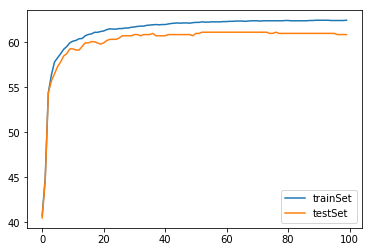

In [463]:
x,y = testPerceptron(100,0.001)

plt.show()

##### 6) Analyse:

Les résultats prédis par nos algorithmes produisent un taux d'accuracy de 60% produisent  Nous pouvons justifier celà en se disant que la feature 'budget' a des foisun impact négatif dans la prédiction de la note. En effet, des fois nous avons de très gros budget pour des films qui ne sont pas très bien notés par les utilisateurs.Nous allons essayer par la suite d'ajouter d'autres features comme la star du film et le producteur pour voir s'il y a un changement

#### 2) En utilisant 3 features

Maintenant, ajoutons une troisieme feature qui est la 'star' du film, nous allons convertir les noms des acteurs en numeric afin de mieux les manipuler et plus facilement les utiliser dans notre modèle. Par la suite, nous créerons notre labeled set et nous ferons un split pour le diviser en train et test comme nous avons fait précedemment.

In [492]:
#copier notre dataFrame
df_p1_2 = movies_df[['budget','gross','star','moy_rating']].copy(deep=True)
df_p1_2.head()


stars_list=list(df_p1_2['star'])


#Convertir les noms des acteurs en numeric
D={}
i=0
for e in np.unique(stars_list):
    D[e]=i
    i=i+1
star_num=[]
k=0
for e in stars_list:
    star_num.append(D[e])
    k=k+1

df_p1_2.drop("star", axis = 1, inplace = True)
df_p1_2['star']=star_num

#inverser les columns pour prédire la moyenne, non pas la star
columnsTitles=["budget","gross","star","moy_rating"]
df_p1_2=df_p1_2.reindex(columns=columnsTitles)

#creer le labeledSet et Normaliser les donnés
columnsX = ["budget", "gross", "star"]
columnY = ["moy_rating"]

#LabeledSet de la 1ere problématique 3 features
LS_P1_2 = ls.LabeledSet(len(columnsX))
LS_P1_2.x = (df_p1_2[columnsX].values - df_p1_2[columnsX].mean().values)/df_p1_2[columnsX].std().values
LS_P1_2.y = df_p1_2[columnY].values.reshape(-1, 1)
LS_P1_2.nb_examples = LS_P1_2.y.shape[0]

print('Le nombre d\'exemples dans la base',LS_P1_2.nb_examples)


#split
LS_P1_2Learn, LS_P1_2Test = split(LS_P1_2, proportion_train = 0.8)
df_p1_2.head()

Le nombre d'exemples dans la base 4108


,budget,gross,star,moy_rating
0,30000000.0,191796233.0,1411,3.920930
1,50000000.0,100475249.0,1205,3.431818
2,25000000.0,69870000.0,1457,3.259615
3,16000000.0,67052156.0,1466,2.357143
4,30000000.0,76594000.0,1345,3.071429


In [506]:
def testPerceptron_p12(N, epsilon):
    perceptron = ClassifierGradientBatch(3, epsilon)
    Y = np.zeros(N)
    Z = np.zeros(N)
    X = np.zeros(N)
    weight = []
    x = []
    y = []
    z = []
    for i in range(N):
        X[i] = i
        Y[i] = perceptron.accuracy(LS_P1_2Learn)
        x.append(perceptron.w[0])
        y.append(perceptron.w[1])
        z.append(perceptron.w[2])
        Z[i] = perceptron.accuracy(LS_P1_2Test)
        perceptron.train(LS_P1_2Learn)
    plt.plot(X,Y, label="trainSet")
    plt.plot(X,Z, label="testSet")
    plt.legend()
    plt.show()
    return x,y,z

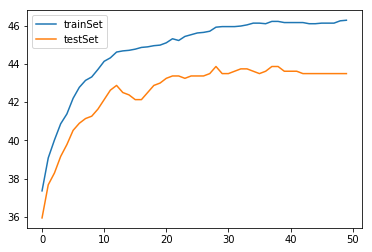

In [509]:
x,y,z = testPerceptron_p12(50,0.001)

plt.show()

##### 6) Analyse

La prédiction faite par notre algorihme en utilisant 3 features (star,budget,gross) donne des résultats moins satisfaisants que celle avec 2 features, l'ajoute de l'attribut 'star' n'a pas apporté une meilleure prédiction au contraire, des fois notre modèle n'atteint meme pas les 35%

## Deuxième problèmatique: La prédiction de la catégorie d'un film 

### Partie 1 - Description du problème

Notre deuxième problèmatique consiste à Prédire la catégorie d'un film, pour celà nous allons commencer par diviser notre problematique et voir le résultat des differentes solutions:
- dans la première nous allons essayer de prédire si notre film appartient à une categorie ou pas en utilisant deux features qui sont la 'star' et le 'rating' (l'age de restriction du film), nous utiliserons les differents algorithme vu en cours qui sont : les arbres de décision, knn, random forest, puis nous comparons les resultats de ces algorithmes

- dans la deuxième nous allons essayer de prédire dans quelle catégorie appartient notre film (multiclass classification):


#### 1- Ce film appartient à cette catégorie ou pas ?

#####  1) une autre étape de prétraitement pour cette problèmatique

Dans l'histogramme ci dessous, nous pouvons voir que notre dataset contient beaucoup de films classifiés dans le genre 'Drama'. Donc nous choisissons ce genre vu qu'il nous fournira une bonne quantité de films pour l’apprentissage.

Voic un histogramme:

C:\Users\Fatah\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


{'Action': 1828, 'Adventure': 1263, 'Animation': 611, 'Children': 664, 'Comedy': 3756, 'Crime': 1199, 'Documentary': 440, 'Drama': 4361, 'Fantasy': 779, 'Film-Noir': 87, 'Horror': 978, 'Musical': 334, 'Mystery': 573, 'Romance': 1596, 'Sci-Fi': 980, 'Thriller': 1894, 'War': 382, 'Western': 167, ' (no genres listed)': 0}


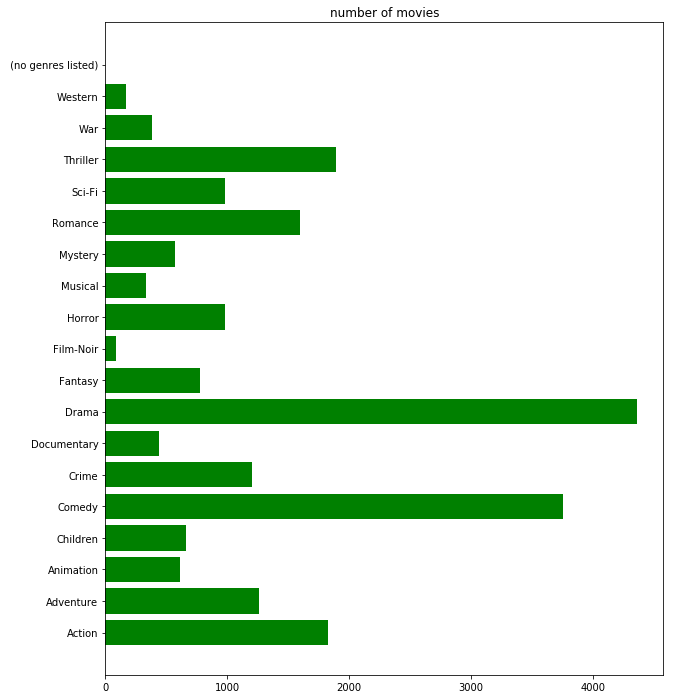

In [147]:
#La fonction suivante déssine l'hsitogramme de nombre de films pour chaque genre donné
def genre_histo():
    dict_genre={genre:0 for genre in list_genres}
    for genre in list_genres:
        is_genre=movies['genres'].str.contains(str(genre))
        for elem in is_genre:
            if elem==True:
                dict_genre[genre]+=1
    print(dict_genre)
    #Afficher le resultat dans un histogramme                
    fig, ax = plt.subplots(figsize=(10, 12))
    columns = dict_genre.keys()
    y_pos = np.arange(len(columns))

    res = [int(e) for e in dict_genre.values()]

    ax.barh(y_pos, res, align='center', color='green', ecolor='black')
    ax.set_yticks(y_pos)
    labelsY=ax.set_yticklabels(columns)

    ax.set_title('number of movies')

    
    return plt.show()
genre_histo()

In [150]:
def split(data, proportion_train):
    train_set = ls.LabeledSet(data.input_dimension)
    test_set = ls.LabeledSet(data.input_dimension) 
    
    for i in range(data.size()):
        if (random.random() < proportion_train):
            train_set.addExample(data.getX(i), data.getY(i))
        else:
            test_set.addExample(data.getX(i),data.getY(i))
    
    return (train_set, test_set) 

- Nous utiliserons les classifieurs codés en TME, pour cela nous allons transformer nos dataframe en LabeledSet mais juste avant, comme nous avons besoin des acteurs et des rating (l'age de restriction du film), nous devons donc transformer nos acteurs en variables discrètes

- Ensuite il faut normaliser les données, la moyenne (le Mu) est de zéro et la varience est de de 1 pour permettre à nos classifieurs de pouvoir utiliser ce labeledSet

- Enfin nous allons spliter nos données avec (methode de validation) , qui va nous donner 80% d'exemples pour le train et 20% pour le test

In [292]:
#copier notre dataFrame
df_p2=movies_df.copy()

stars_list=list(df_p2['star'])
rating_list=list(df_p2['rating'])

#Convertir les noms des acteurs et les noms des rating en numeric
D={}
i=0
for e in np.unique(stars_list):
    D[e]=i
    i=i+1
star_num=[]
k=0
for e in stars_list:
    star_num.append(D[e])
    k=k+1

D={}
i=0
for e in np.unique(rating_list):
    D[e]=i
    i=i+1
rating_num=[]
k=0
for e in rating_list:
    rating_num.append(D[e])
    k=k+1
     
df_p2.drop("rating", axis = 1, inplace = True)
df_p2.drop("star", axis = 1, inplace = True)
df_p2['rating']=rating_num
df_p2['star']=star_num


#creer le labeledSet et Normaliser les donnés
columnsX = ["rating", "star"]
columnY = ["drama"]

#LabeledSet de la 2eme problématique
LS_P2 = ls.LabeledSet(len(columnsX))
LS_P2.x = (df_p2[columnsX].values - df_p2[columnsX].mean().values)/df_p2[columnsX].std().values
LS_P2.y = df_p2[columnY].values.reshape(-1, 1)
LS_P2.nb_examples = LS_P2.y.shape[0]

print('Le nombre d\'exemples dans la base',LS_P2.nb_examples)
print('Le nombre d\'exemples du genre drama dans la base',(LS_P2.y==1).sum())
print('Le nombre d\'exemples du genre non-drama dans la base',(LS_P2.y==-1).sum())

#split
LS_P2Learn, LS_P2Test = split(LS_P2, proportion_train = 0.8)

Le nombre d'exemples dans la base 4108
Le nombre d'exemples du genre drama dans la base 1956
Le nombre d'exemples du genre non-drama dans la base 2152


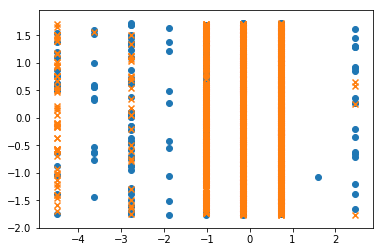

In [180]:
ut.plot2DSet(LS_P2)

##### 2) Modèle:

Pour pouvoir classifier le genre 'drama' ou 'non-drama', nous allons utiliser d'abord le KNN, puis les arbres (simple et bagging), le gradient stochastique puis le kernelPoly

##### 3) Code 

In [182]:
# classifieur knn de la problemtique 2 numéro 1
C_KNN_P2_1=cl.ClassifierKNN(len(columnsX), 3)


In [226]:
c_arbre_P2_1 = ArbreDecision(0.005)


In [232]:
c_bagging_P2_1 = BaggingTreeOOB(20, 0.3, 0.005, True)

##### 4) Protocole expérimental

In [183]:
print('demarrage de l\'apprentissge du knn')
C_KNN_P2_1.train(LS_P2Learn)


demarrage de l'apprentissge du knn


In [227]:
print('demarrage de l\'apprentissge de l\'arbre')
c_arbre_P2_1.train(LS_P2Learn)

demarrage de l'apprentissge de l'arbre


In [234]:
print('demarrage de l\'apprentissge de bagging tree')
c_bagging_P2_1.train(LS_P2Learn)

demarrage de l'apprentissge de bagging tree


##### 5) Résultats

##### KNN:

accuracy du sur le set_training 76.26553501060927 Accuracy sur le set_test 59.950556242274416


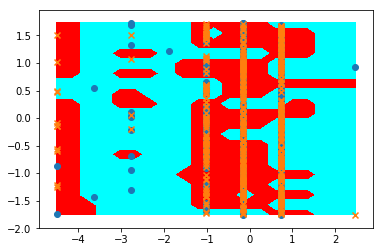

In [186]:
ut.plot_frontiere(LS_P2Test,C_KNN_P2_1,20)
ut.plot2DSet(LS_P2Test)
print('accuracy du sur le set_training',C_KNN_P2_1.accuracy(LS_P2Learn), 'Accuracy sur le set_test',C_KNN_P2_1.accuracy(LS_P2Test))

##### Arbre de décision

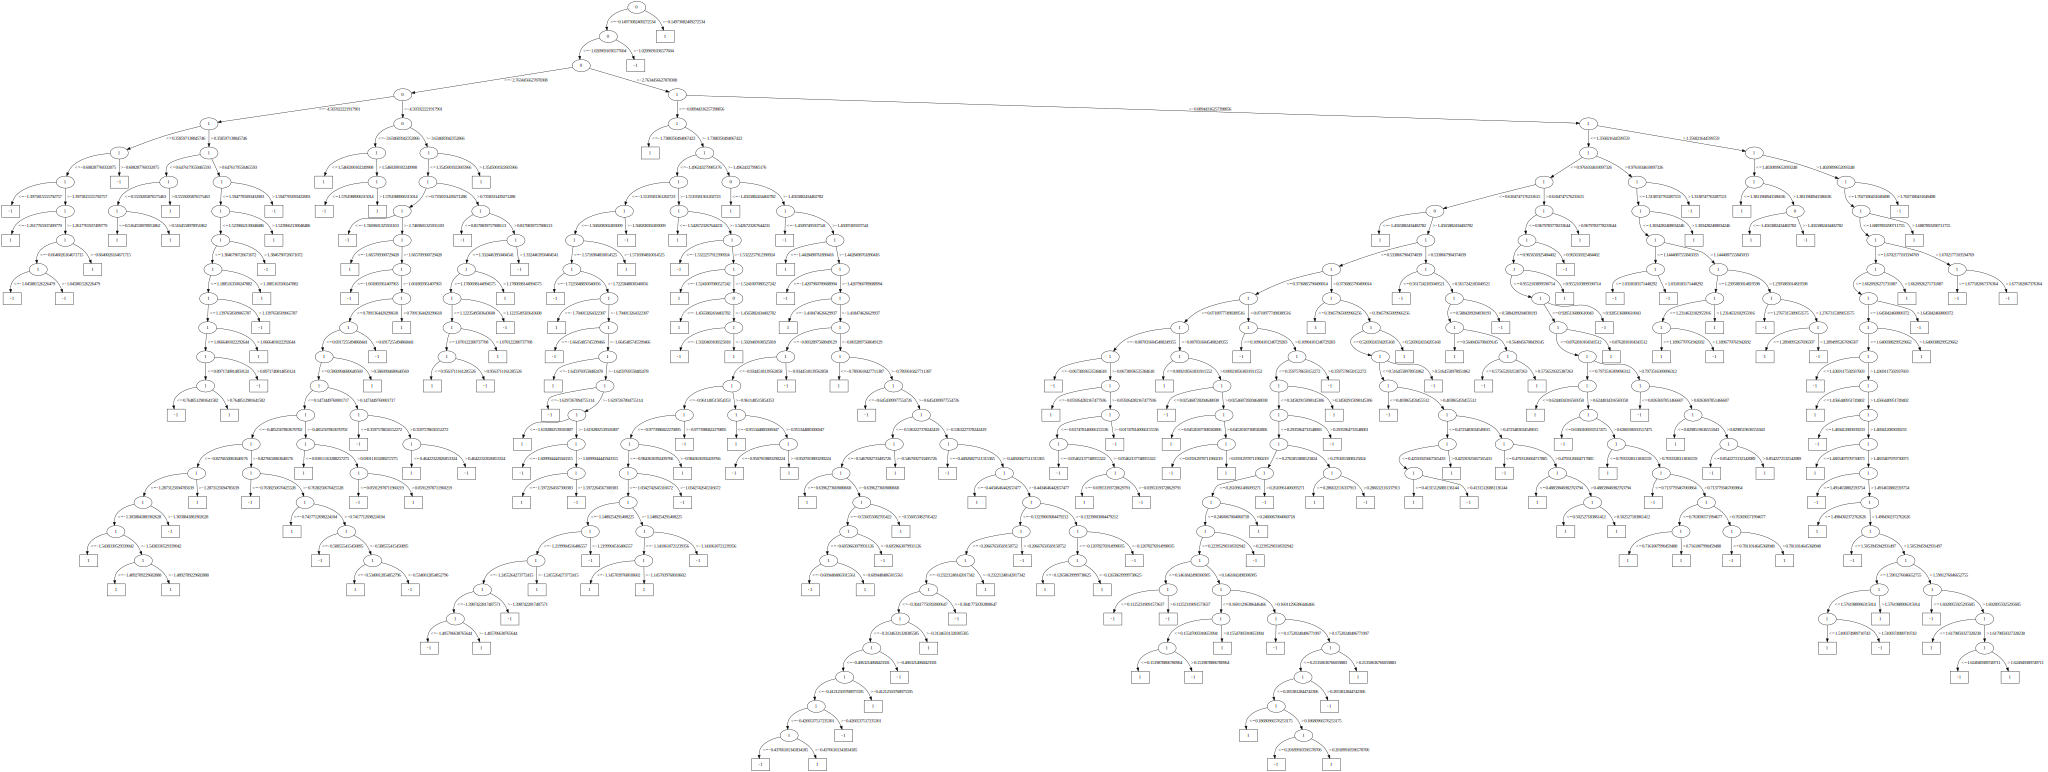

In [228]:
c_arbre_P2_1.plot()

In [238]:
print('accuracy du sur le set_training',c_arbre_P2_1.accuracy(LS_P2Learn), 'Accuracy sur le set_test',c_arbre_P2_1.accuracy(LS_P2Test))

accuracy du sur le set_training 63.35253107002122 Accuracy sur le set_test 60.321384425216316


##### Arbre Bagging 

In [239]:
print('accuracy du sur le set_training',c_bagging_P2_1.accuracy(LS_P2Learn), 'Accuracy sur le set_test',c_bagging_P2_1.accuracy(LS_P2Test))

accuracy du sur le set_training 72.77963019096696 Accuracy sur le set_test 60.81582200247219


#### 6)Analyse:

Les résultats prédis par nos algorithmes produisent tous à peu près un meme taux d'accuracy et qui est de 60%.
Nous pouvons dire que peut etre ces deux features sont insufisantes et ne contiennent pas assez d'informations pour mieux prédire toutes seules la categorie du film mais aussi, ceci à été obtenu avec l'entrainement sur tous les films, y a t il une difference si nous entrainons nos modèles sur par exemple les films qui n'ont pas moins de 70 votes?
Nous allons essayer par la suite d'ajouter d'autres features comme l'ecrivain et le producteur, mais aussi de filtrer le dataset pour travailler qu'avec les exemples qui ont au minimum 70 votes afin de voir si il y a une améliorations dans le taux de notre Accuracy

# SUITE DANS LE DEUXIEME FICHIER (Cas non supervisé)